In [2]:
from sklearn.feature_selection import SelectFromModel,SelectPercentile, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt
import pandas as pd
import numpy as np


This notebook classifies the lithology in the Gaspe outcrop, taken by Seckinger(2022). The  features were found using the features.py script. Point cloud and features are found in Gaspe_data folder. 

## I. Data - Preprocessing

In [2]:
#TEST
#load files_test
r_01xyz1 = pd.read_csv('0.1test.txt',index_col=0)
r_02xyz1 = pd.read_csv('0.2test.txt',index_col=0)
r_05xyz1 = pd.read_csv('0.5test.txt',index_col=0)
lab_test = pd.read_csv('LAB_core_test.txt',index_col=0)

In [3]:
#######Concatenate the features data frames
#TEST SET

#0.1
r1_01 = r_01xyz1.iloc[:,3:r_01xyz1.shape[1]-1] #Excluding X,Y,Z,labels
r1_01 = r1_01.add_suffix('_01')

#0.2
r1_02 = r_02xyz1.iloc[:,3:r_02xyz1.shape[1]-1] #Excluding X,Y,Z,labels
r1_02 = r1_02.add_suffix('_02')

#0.5
r1_05 = r_05xyz1.iloc[:,3:r_05xyz1.shape[1]-1] #Excluding X,Y,Z,labels
#add sufix
r1_05 = r1_05.add_suffix('_05')

In [4]:
#concatenate the data frames
X_test = pd.concat([r1_01,r1_02,r1_05,lab_test], axis=1)
######dataframe of labels
y_test = r_05xyz1.iloc[:,r_05xyz1.shape[1]-1]

In [5]:
#TRAIN
#load files_train
r_01xyz2 = pd.read_csv('0.1train.txt',index_col=0)
r_02xyz2 = pd.read_csv('0.2train.txt',index_col=0)
r_05xyz2 = pd.read_csv('0.5train.txt',index_col=0)
lab_train = pd.read_csv('LAB_core_train.txt',index_col=0)

In [6]:
#######Concatenate the features data frames
#TRAIN SET

#0.1
r1_01 = r_01xyz2.iloc[:,3:r_01xyz1.shape[1]-1] #Excluding X,Y,Z,labels
r1_01 = r1_01.add_suffix('_01')

#0.2
r1_02 = r_02xyz2.iloc[:,3:r_02xyz1.shape[1]-1] #Excluding X,Y,Z,labels
r1_02 = r1_02.add_suffix('_02')

#0.5
r1_05 = r_05xyz2.iloc[:,3:r_05xyz1.shape[1]-1] #Excluding X,Y,Z,labels
#add sufix
r1_05 = r1_05.add_suffix('_05')

In [7]:
#concatenate the data frames
X_train = pd.concat([r1_01,r1_02,r1_05,lab_train], axis=1)
######dataframe of labels
y_train = r_05xyz2.iloc[:,r_01xyz2.shape[1]-1]

In [8]:
X_test.shape, y_test.shape

((285930, 162), (285930,))

In [9]:
X_train.shape, y_train.shape

((704826, 162), (704826,))

## II - Engineering Features

### II.I  Univariate Statistics

We compute if there is a statistically significance relationship between each feature and the target. The Select Percentile option, selects a fixed percentage of features. 

In [10]:
## use f_classif (the default) and SelectPercentile to select 50% of the features

select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

#transform training set
X_train_selected = select.transform(X_train)
print('X_train.shape:{}'.format(X_train.shape))
print('X_train_selected.shape:{}'.format(X_train_selected.shape))

X_train.shape:(704826, 162)
X_train_selected.shape:(704826, 81)


We can find out which features have been selected using the get_support method, which returns a Boolean mask of the selected features.

Text(0.5, 0, 'Sample Index')

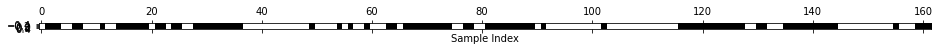

In [13]:
mask = select.get_support()

#names of features
feat_names= X_train.columns

#new set of features with 50% of the features
us_50 = feat_names[mask]

plt.matshow(mask.reshape(1,-1),cmap='gray_r')
plt.xlabel('Sample Index')

In [14]:
## use f_classif (the default) and SelectPercentile to select 30% of the features

select = SelectPercentile(percentile=30)
select.fit(X_train, y_train)

#transform training set
X_train_selected = select.transform(X_train)
print('X_train.shape:{}'.format(X_train.shape))
print('X_train_selected.shape:{}'.format(X_train_selected.shape))

X_train.shape:(704826, 162)
X_train_selected.shape:(704826, 49)


Text(0.5, 0, 'Sample Index')

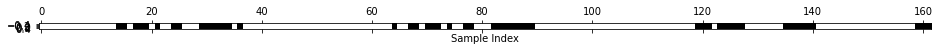

In [15]:
mask = select.get_support()

#new set of features with 30% of the features
us_30 = feat_names[mask]

plt.matshow(mask.reshape(1,-1),cmap='gray_r')
plt.xlabel('Sample Index')

In [16]:
## use f_classif (the default) and SelectPercentile to select 80% of the features

select = SelectPercentile(percentile=80)
select.fit(X_train, y_train)

#transform training set
X_train_selected = select.transform(X_train)
print('X_train.shape:{}'.format(X_train.shape))
print('X_train_selected.shape:{}'.format(X_train_selected.shape))

X_train.shape:(704826, 162)
X_train_selected.shape:(704826, 129)


Text(0.5, 0, 'Sample Index')

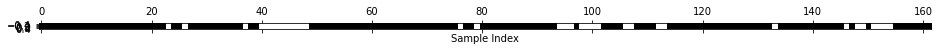

In [17]:
mask = select.get_support()

#new set of features with 80% of the features
us_80 = feat_names[mask]

plt.matshow(mask.reshape(1,-1),cmap='gray_r')
plt.xlabel('Sample Index')

### II.II Model-Based Feature Selection

Uses a supervised ML model to judge the importance of each feature, and keeps only the most important ones.

**The supervised model that is used for feature selection doesn't need to be the same model that is used for the final supervised model.**

In contrast to univariate selection, model-based selection considers all features at once, and so you can capture interactions (if the model can capture them).

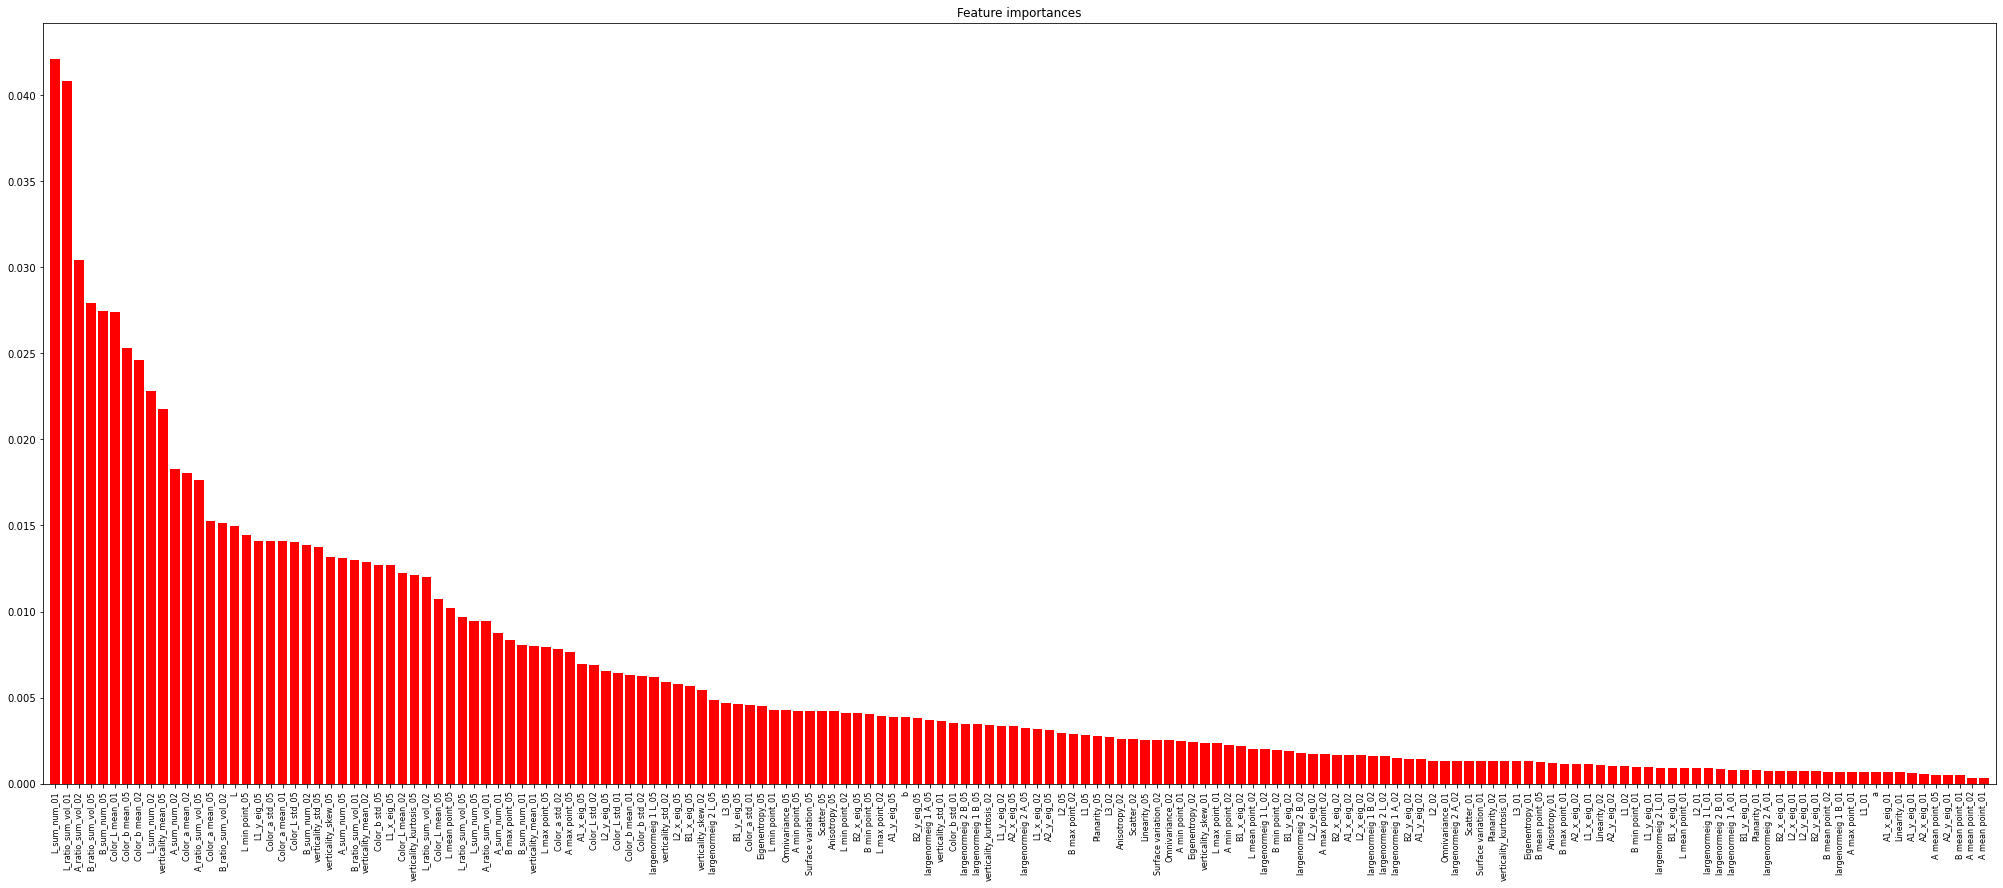

In [18]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100,random_state=0))
sel.fit(X_train, y_train)
    
#calculate the importances
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
    
#plot the importances
r = X_train.columns.tolist()
labels1 = [r[i] for i in indices]
    
     
plt.figure(figsize=(35, 14))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), labels1,fontsize=8,rotation = 90)
plt.xlim([-1, X_train.shape[1]])
plt.savefig('random_forest.jpg')    

### II. III Iterative Feature Selection

In iterative feature selection, a series of models are built, with varying number of features.

One particular method of this kind is **recursive feature elimination**, which starts with all features,builds a model, and discards the least important feature according to the model.

I am going to use the same random forest model that I used in the last section.

In [78]:
# select = RFE(RandomForestClassifier(n_estimators = 100,random_state=0),n_features_to_select=81)
# select.fit(X_train, y_train)

# mask = select.get_support()

# #new set of features with 50% of the features
# ifs_50 = feat_names[mask]


## III. Feature Sets

In [19]:
#Make a copy of the training set
X_traincopy = X_train.copy()
#Make a copy of the test set
X_testcopy = X_test.copy()

###   us_50 set

In [20]:
X_train_us50 = X_traincopy[us_50]
X_test_us50 = X_testcopy[us_50]

In [21]:
X_train_us50.columns

Index(['L2_01', 'L3_01', 'Omnivariance_01', 'Planarity_01', 'Linearity_01',
       'verticality_std_01', 'Color_L std_01', 'Color_a std_01',
       'Color_b std_01', 'Color_L mean_01', 'Color_a mean_01',
       'Color_b mean_01', 'L min point_01', 'L max point_01', 'A min point_01',
       'A max point_01', 'B max point_01', 'L_sum_num_01', 'A_sum_num_01',
       'B_sum_num_01', 'L_ratio_sum_vol_01', 'A_ratio_sum_vol_01',
       'B_ratio_sum_vol_01', 'largenormeig 1 L_01', 'largenormeig 2 L_01',
       'B1_x_eig_01', 'L2_02', 'Omnivariance_02', 'Planarity_02',
       'verticality_mean_02', 'verticality_std_02', 'verticality_kurtosis_02',
       'Color_L std_02', 'Color_a std_02', 'Color_b std_02', 'Color_L mean_02',
       'Color_a mean_02', 'Color_b mean_02', 'L mean point_02',
       'L min point_02', 'A min point_02', 'A max point_02', 'B max point_02',
       'L_sum_num_02', 'A_sum_num_02', 'B_sum_num_02', 'L_ratio_sum_vol_02',
       'A_ratio_sum_vol_02', 'B_ratio_sum_vol_02', 'la

## us_30

In [22]:
X_train_us30 = X_traincopy[us_30]
X_test_us30 = X_testcopy[us_30]

In [23]:
X_test_us30.columns

Index(['Color_L std_01', 'Color_a std_01', 'Color_L mean_01',
       'Color_a mean_01', 'Color_b mean_01', 'L min point_01',
       'A min point_01', 'A max point_01', 'L_sum_num_01', 'A_sum_num_01',
       'B_sum_num_01', 'L_ratio_sum_vol_01', 'A_ratio_sum_vol_01',
       'B_ratio_sum_vol_01', 'largenormeig 2 L_01', 'verticality_std_02',
       'Color_L std_02', 'Color_a std_02', 'Color_L mean_02',
       'Color_a mean_02', 'Color_b mean_02', 'L min point_02',
       'A min point_02', 'A max point_02', 'L_sum_num_02', 'A_sum_num_02',
       'B_sum_num_02', 'L_ratio_sum_vol_02', 'A_ratio_sum_vol_02',
       'B_ratio_sum_vol_02', 'largenormeig 1 L_02', 'largenormeig 2 L_02',
       'verticality_kurtosis_05', 'Color_L std_05', 'Color_a std_05',
       'Color_L mean_05', 'Color_a mean_05', 'Color_b mean_05',
       'L mean point_05', 'L min point_05', 'L_sum_num_05', 'A_sum_num_05',
       'B_sum_num_05', 'L_ratio_sum_vol_05', 'A_ratio_sum_vol_05',
       'B_ratio_sum_vol_05', 'L', 'a', '

## us_80

In [24]:
X_train_us80 = X_traincopy[us_80]
X_test_us80 = X_testcopy[us_80]
X_test_us80.columns

Index(['L1_01', 'L2_01', 'L3_01', 'Omnivariance_01', 'Eigenentropy_01',
       'Anisotropy_01', 'Planarity_01', 'Linearity_01', 'Surface variation_01',
       'Scatter_01',
       ...
       'largenormeig 1 B_05', 'L1_x_eig_05', 'L2_y_eig_05', 'B1_x_eig_05',
       'B1_y_eig_05', 'B2_x_eig_05', 'B2_y_eig_05', 'L', 'a', 'b'],
      dtype='object', length=129)

###  First set of Features (green) 

In [25]:
fsf = labels1[0:49]

#Filter train and data set with only the first set of features including absolute color features 
X_train_fsf = X_traincopy.loc[:,fsf]
X_test_fsf = X_testcopy.loc[:,fsf]
X_train_fsf.columns

Index(['L_sum_num_01', 'L_ratio_sum_vol_01', 'A_ratio_sum_vol_02',
       'B_ratio_sum_vol_05', 'B_sum_num_05', 'Color_L mean_01',
       'Color_b mean_05', 'Color_b mean_02', 'L_sum_num_02',
       'verticality_mean_05', 'A_sum_num_02', 'Color_a mean_02',
       'A_ratio_sum_vol_05', 'Color_a mean_05', 'B_ratio_sum_vol_02', 'L',
       'L min point_05', 'L1_y_eig_05', 'Color_a std_05', 'Color_a mean_01',
       'Color_L std_05', 'B_sum_num_02', 'verticality_std_05',
       'verticality_skew_05', 'A_sum_num_05', 'B_ratio_sum_vol_01',
       'verticality_mean_02', 'Color_b std_05', 'L1_x_eig_05',
       'Color_L mean_02', 'verticality_kurtosis_05', 'L_ratio_sum_vol_02',
       'Color_L mean_05', 'L mean point_05', 'L_ratio_sum_vol_05',
       'L_sum_num_05', 'A_ratio_sum_vol_01', 'A_sum_num_01', 'B max point_05',
       'B_sum_num_01', 'verticality_mean_01', 'L max point_05',
       'Color_a std_02', 'A max point_05', 'A1_x_eig_05', 'Color_L std_02',
       'L2_y_eig_05', 'Color_L std_0

### Second set of features (yellow)

In [26]:
ssf = labels1[0:81]

#Filter train and  test data set with only the first set of features including absolute color features 
X_train_ssf = X_traincopy.loc[:,ssf]
X_test_ssf = X_testcopy.loc[:,ssf]
X_test_ssf.columns

Index(['L_sum_num_01', 'L_ratio_sum_vol_01', 'A_ratio_sum_vol_02',
       'B_ratio_sum_vol_05', 'B_sum_num_05', 'Color_L mean_01',
       'Color_b mean_05', 'Color_b mean_02', 'L_sum_num_02',
       'verticality_mean_05', 'A_sum_num_02', 'Color_a mean_02',
       'A_ratio_sum_vol_05', 'Color_a mean_05', 'B_ratio_sum_vol_02', 'L',
       'L min point_05', 'L1_y_eig_05', 'Color_a std_05', 'Color_a mean_01',
       'Color_L std_05', 'B_sum_num_02', 'verticality_std_05',
       'verticality_skew_05', 'A_sum_num_05', 'B_ratio_sum_vol_01',
       'verticality_mean_02', 'Color_b std_05', 'L1_x_eig_05',
       'Color_L mean_02', 'verticality_kurtosis_05', 'L_ratio_sum_vol_02',
       'Color_L mean_05', 'L mean point_05', 'L_ratio_sum_vol_05',
       'L_sum_num_05', 'A_ratio_sum_vol_01', 'A_sum_num_01', 'B max point_05',
       'B_sum_num_01', 'verticality_mean_01', 'L max point_05',
       'Color_a std_02', 'A max point_05', 'A1_x_eig_05', 'Color_L std_02',
       'L2_y_eig_05', 'Color_L std_0

### Third set of Features (purple)

In [27]:
tsf = labels1[0:129]

#Filter train and  test data set with only the first set of features including absolute color features 
X_train_tsf = X_traincopy.loc[:,tsf]
X_test_tsf = X_testcopy.loc[:,tsf]
X_test_tsf.columns

Index(['L_sum_num_01', 'L_ratio_sum_vol_01', 'A_ratio_sum_vol_02',
       'B_ratio_sum_vol_05', 'B_sum_num_05', 'Color_L mean_01',
       'Color_b mean_05', 'Color_b mean_02', 'L_sum_num_02',
       'verticality_mean_05',
       ...
       'Surface variation_01', 'Planarity_02', 'verticality_kurtosis_01',
       'L3_01', 'Eigenentropy_01', 'B mean point_05', 'Anisotropy_01',
       'B max point_01', 'A2_x_eig_02', 'L1_x_eig_01'],
      dtype='object', length=129)

## III. Feature Normalization

In [30]:
# Create the scaler obeject with a range of 0-1
scaler = MinMaxScaler(feature_range =(0,1))

#Fit on the data
scaler.fit(X_train)
#Transform both the training and testing data
X_trains = scaler.transform(X_train)


#Fit on the data
scaler.fit(X_test)
#Transform both the training and testing data
X_tests = scaler.transform(X_test)

### us_50

In [31]:
X_train_us50 = X_traincopy[us_50]
X_test_us50 = X_testcopy[us_50]

In [33]:
# Create the scaler obeject with a range of 0-1
scaler_us50 = MinMaxScaler(feature_range =(0,1))

# #Fit on the data
scaler_us50.fit(X_train_us50)

# #Transform both the training and testing data
X_train_us50_norm = scaler_us50.transform(X_train_us50)

# #Fit on the data
scaler_us50.fit(X_train_us50)
X_test_us50_norm = scaler_us50.transform(X_train_us50)

### us_30

In [37]:
X_train_us30 = X_traincopy[us_30]
X_test_us30 = X_testcopy[us_30]

In [38]:
# Create the scaler obeject with a range of 0-1
scaler_us30 = MinMaxScaler(feature_range =(0,1))

# #Fit on the data
scaler_us30.fit(X_train_us30)

# #Transform both the training and testing data
X_train_us30_norm = scaler_us30.transform(X_train_us30)

# #Fit on the data
scaler_us30.fit(X_train_us30)
X_test_us30_norm = scaler_us30.transform(X_train_us30)

### us_80

In [39]:
X_train_us80 = X_traincopy[us_80]
X_test_us80 = X_testcopy[us_80]

In [40]:
# Create the scaler obeject with a range of 0-1
scaler_us80 = MinMaxScaler(feature_range =(0,1))

# #Fit on the data
scaler_us80.fit(X_train_us80)

# #Transform both the training and testing data
X_train_us80_norm = scaler_us80.transform(X_train_us80)

# #Fit on the data
scaler_us80.fit(X_train_us80)
X_test_us80_norm = scaler_us80.transform(X_train_us80)

### First set of Features (green) including absolute color features

In [41]:
# Create the scaler obeject with a range of 0-1
scaler_fsf = MinMaxScaler(feature_range =(0,1))

# #Fit on the data
scaler_fsf.fit(X_train_fsf)

# #Transform both the training and testing data
X_train_fsf_norm = scaler_fsf.transform(X_train_fsf)

# #Fit on the data
scaler_fsf.fit(X_test_fsf)
X_test_fsf_norm = scaler_fsf.transform(X_test_fsf)

###  Second set of features (yellow) including absolute color features

In [42]:
#Create the scaler obeject with a range of 0-1
scaler_ssf = MinMaxScaler(feature_range =(0,1))

#Fit on the data
scaler_ssf.fit(X_train_ssf)

#Transform both the training and testing data
X_train_ssf_norm = scaler_ssf.transform(X_train_ssf)

scaler_ssf.fit(X_test_ssf)
X_test_ssf_norm = scaler_ssf.transform(X_test_ssf)

### Third set of features (purple) not including absolute features

In [43]:
# Create the scaler obeject with a range of 0-1
scaler_nac = MinMaxScaler(feature_range =(0,1))

#Fit on the data
scaler_nac.fit(X_train_tsf)

#Transform both the training and testing data
X_train_tsf_norm = scaler_nac.transform(X_train_tsf)

scaler_nac.fit(X_test_tsf)
X_test_tsf_norm = scaler_nac.transform(X_test_tsf)

## IV. Machine Learning to Classify Lithology 

### IV.I Random Forest

### us_50

In [51]:
#Create the model

RandomFores_us50 = RandomForestClassifier(random_state=0)

#Fit the model on the training data
RandomFores_us50.fit(X_train_us50,y_train)

#Make predictions on the test data
predictions_us50 = RandomFores_us50.predict(X_test_us50)

#Evaluate the model MAE
mae_rf_us50 = np.mean(abs(predictions_us50-y_test))

# Accuracy score
acc_rf_us50 = accuracy_score(y_test, predictions_us50)

#F1-Score
F1_micro_rf_us50 = f1_score(y_test, predictions_us50, average ='micro')

#F1-Score
F1_macro_rf_us50 = f1_score(y_test, predictions_us50, average ='macro')

#F1-Score
F1_weigh_rf_us50 = f1_score(y_test, predictions_us50, average = 'weighted')


### us_30

In [53]:
#Create the model

RandomFores_us30 = RandomForestClassifier(random_state=0)

#Fit the model on the training data
RandomFores_us30.fit(X_train_us30,y_train)

#Make predictions on the test data
predictions_us30 = RandomFores_us30.predict(X_test_us30)

#Evaluate the model MAE
mae_rf_us30 = np.mean(abs(predictions_us30-y_test))

# Accuracy score
acc_rf_us30 = accuracy_score(y_test, predictions_us30)

#F1-Score
F1_micro_rf_us30 = f1_score(y_test, predictions_us30, average ='micro')

#F1-Score
F1_macro_rf_us30 = f1_score(y_test, predictions_us30, average ='macro')

#F1-Score
F1_weigh_rf_us30 = f1_score(y_test, predictions_us30, average = 'weighted')

### us_80

In [54]:
#Create the model

RandomFores_us80 = RandomForestClassifier(random_state=0)

#Fit the model on the training data
RandomFores_us80.fit(X_train_us80,y_train)

#Make predictions on the test data
predictions_us80 = RandomFores_us80.predict(X_test_us80)

#Evaluate the model MAE
mae_rf_us80 = np.mean(abs(predictions_us80-y_test))

# Accuracy score
acc_rf_us80 = accuracy_score(y_test, predictions_us80)

#F1-Score
F1_micro_rf_us80 = f1_score(y_test, predictions_us80, average ='micro')

#F1-Score
F1_macro_rf_us80 = f1_score(y_test, predictions_us80, average ='macro')

#F1-Score
F1_weigh_rf_us80 = f1_score(y_test, predictions_us80, average = 'weighted')

### First Set of Features

In [55]:
#Create the model

RandomFores_fsf = RandomForestClassifier(random_state=0)

#Fit the model on the training data
RandomFores_fsf.fit(X_train_fsf,y_train)

#Make predictions on the test data
predictions_fsf = RandomFores_fsf.predict(X_test_fsf)

#Evaluate the model MAE
mae_rf_fsf = np.mean(abs(predictions_fsf-y_test))

# Accuracy score
acc_rf_fsf = accuracy_score(y_test, predictions_fsf)

#F1-Score
F1_micro_rf_fsf = f1_score(y_test, predictions_fsf, average ='micro')

#F1-Score
F1_macro_rf_fsf = f1_score(y_test, predictions_fsf, average ='macro')

#F1-Score
F1_weigh_rf_fsf = f1_score(y_test, predictions_fsf, average = 'weighted')

### Second Set of Features

In [57]:
#Create the model

RandomFores_ssf = RandomForestClassifier(random_state=0)

#Fit the model on the training data
RandomFores_ssf.fit(X_train_ssf,y_train)

#Make predictions on the test data
predictions_ssf = RandomFores_ssf.predict(X_test_ssf)

#Evaluate the model MAE
mae_rf_ssf = np.mean(abs(predictions_ssf-y_test))

# Accuracy score
acc_rf_ssf = accuracy_score(y_test, predictions_ssf)

#F1-Score
F1_micro_rf_ssf = f1_score(y_test, predictions_ssf, average ='micro')

#F1-Score
F1_macro_rf_ssf = f1_score(y_test, predictions_ssf, average ='macro')

#F1-Score
F1_weigh_rf_ssf = f1_score(y_test, predictions_ssf, average = 'weighted')

### Third Set of Features

In [ ]:
#Create a svm Classifier
clf = svm.SVC(random_state=0) 

#Train the model using the training sets
clf.fit(X_train_tsf_norm , y_train)

#Predict the response for test dataset
y_pred_tsf_SVM = clf.predict(X_test_tsf_norm )

#Evaluate the model MAE
mae_svm_tsf = np.mean(abs(y_pred_tsf_SVM-y_test))

# Accuracy score
acc_svm_tsf = accuracy_score(y_test, y_pred_tsf_SVM)

#F1-Score
F1_micro_svm_tsf = f1_score(y_test, y_pred_tsf_SVM, average ='micro')

#F1-Score
F1_macro_svm_tsf = f1_score(y_test, y_pred_tsf_SVM, average ='macro')

#F1-Score
F1_weigh_svm_tsf = f1_score(y_test, y_pred_tsf_SVM, average = 'weighted')

### All set of Features

In [58]:
#Create the model

RandomFores = RandomForestClassifier(random_state=0)

#Fit the model on the training data
RandomFores.fit(X_train,y_train)

#Make predictions on the test data
predictions = RandomFores.predict(X_test)

#Evaluate the model MAE
mae_rf = np.mean(abs(predictions-y_test))

# Accuracy score
acc_rf = accuracy_score(y_test, predictions)

#F1-Score
F1_micro_rf = f1_score(y_test, predictions, average ='micro')

#F1-Score
F1_macro_rf = f1_score(y_test, predictions, average ='macro')

#F1-Score
F1_weigh_rf = f1_score(y_test, predictions, average = 'weighted')

### Accuracy Comparison

In [ ]:
labels_accu_rf = ['acc_rf_us50','acc_rf_us30','acc_rf_us80','acc_rf_fsf','acc_rf_ssf','acc_rf_tsf','acc_rf']
accu_rf_values = [acc_rf_us50,acc_rf_us30,acc_rf_us80,acc_rf_fsf,acc_rf_ssf, acc_rf_tsf, acc_rf]


# Figure Size
fig, ax = plt.subplots(figsize =(10, 6))

# Horizontal Bar Plot
ax.barh(labels_accu_rf, accu_rf_values)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 1.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y()+0.5,
    str(round((i.get_width()), 4)),
    fontsize = 10, fontweight ='bold',
    color ='grey')

# Add Plot Title
ax.set_title('Accuracy for Random Forest',
             loc ='left', )

plt.savefig('ACC_RF.jpg')

# Show Plot
plt.show()

## F1-Score/Macro

In [ ]:
labels_accu_rf = ['F1_macro_rf_us50','F1_macro_rf_us30','F1_macro_rf_us80','F1_macro_rf_fsf','F1_macro_rf_ssf','F1_macro_rf_tsf','F1_macro_rf']
accu_rf_values = [F1_macro_rf_us50,F1_macro_rf_us30,F1_macro_rf_us80,F1_macro_rf_fsf,F1_macro_rf_ssf,F1_macro_rf_tsf,F1_macro_rf]


# Figure Size
fig, ax = plt.subplots(figsize =(10, 6))

# Horizontal Bar Plot
ax.barh(labels_accu_rf, accu_rf_values)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 1.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y()+0.5,
    str(round((i.get_width()), 4)),
    fontsize = 10, fontweight ='bold',
    color ='grey')

# Add Plot Title
ax.set_title('F1-Score-macro',
             loc ='left', )

plt.savefig('F1_macro_RF.jpg')

# Show Plot
plt.show()

### IV.V.II Support Vector Machine (Normalize Feature)

### us50

In [ ]:
#Create a svm Classifier
clf_us50_norm = svm.SVC(random_state=0) 

#Train the model using the training sets
clf_us50_norm.fit(X_train_us50_norm, y_train)

#Predict the response for test dataset
y_pred_us50_SVM = clf_us50_norm.predict(X_test_us50_norm)

#Evaluate the model MAE
mae_svm_us50 = np.mean(abs(y_pred_us50_SVM-y_test))

# Accuracy score
acc_svm_us50 = accuracy_score(y_test, y_pred_us50_SVM)

#F1-Score
F1_micro_svm_us50 = f1_score(y_test, y_pred_us50_SVM, average ='micro')

#F1-Score
F1_macro_svm_us50 = f1_score(y_test, y_pred_us50_SVM, average ='macro')

#F1-Score
F1_weigh_svm_us50 = f1_score(y_test, y_pred_us50_SVM, average = 'weighted')

### us30

In [ ]:
#Create a svm Classifier
clf_us30_norm = svm.SVC(random_state=0) 

#Train the model using the training sets
clf_us30_norm.fit(X_train_us30_norm, y_train)

#Predict the response for test dataset
y_pred_us30_SVM = clf_us30_norm.predict(X_test_us30_norm)

#Evaluate the model MAE
mae_svm_us30 = np.mean(abs(y_pred_us30_SVM-y_test))

# Accuracy score
acc_svm_us30 = accuracy_score(y_test, y_pred_us30_SVM)

#F1-Score
F1_micro_svm_us30 = f1_score(y_test, y_pred_us30_SVM, average ='micro')

#F1-Score
F1_macro_svm_us30 = f1_score(y_test, y_pred_us30_SVM, average ='macro')

#F1-Score
F1_weigh_svm_us30 = f1_score(y_test, y_pred_us30_SVM, average = 'weighted')

### us80

In [ ]:
#Create a svm Classifier
clf_us80_norm = svm.SVC(random_state=0) 

#Train the model using the training sets
clf_us80_norm.fit(X_train_us80_norm, y_train)

#Predict the response for test dataset
y_pred_us80_SVM = clf_us80_norm.predict(X_test_us80_norm)

#Evaluate the model MAE
mae_svm_us80 = np.mean(abs(y_pred_us80_SVM-y_test))

# Accuracy score
acc_svm_us80 = accuracy_score(y_test, y_pred_us80_SVM)

#F1-Score
F1_micro_svm_us80 = f1_score(y_test, y_pred_us80_SVM, average ='micro')

#F1-Score
F1_macro_svm_us80 = f1_score(y_test, y_pred_us80_SVM, average ='macro')

#F1-Score
F1_weigh_svm_us80 = f1_score(y_test, y_pred_us80_SVM, average = 'weighted')

### First set of Features (yellow)

In [ ]:
#Create a svm Classifier
clf_fsf = svm.SVC(random_state=0) 

#Train the model using the training sets
clf_fsf.fit(X_train_fsf_norm, y_train)

#Predict the response for test dataset
y_pred_fsf_SVM = clf_fsf.predict(X_test_fsf_norm)

#Evaluate the model MAE
mae_svm_fsf = np.mean(abs(y_pred_fsf_SVM-y_test))

# Accuracy score
acc_svm_fsf = accuracy_score(y_test, y_pred_fsf_SVM)

#F1-Score
F1_micro_svm_fsf = f1_score(y_test, y_pred_fsf_SVM, average ='micro')

#F1-Score
F1_macro_svm_fsf = f1_score(y_test, y_pred_fsf_SVM, average ='macro')

#F1-Score
F1_weigh_svm_fsf = f1_score(y_test, y_pred_fsf_SVM, average = 'weighted')

### Second set of features (blue)

In [ ]:
#Create a svm Classifier
clf_ssf_norm = svm.SVC(random_state=0) 

#Train the model using the training sets
clf_ssf_norm.fit(X_train_ssf_norm, y_train)

#Predict the response for test dataset
y_pred_ssf_SVM = clf_ssf_norm.predict(X_test_ssf_norm)

#Evaluate the model MAE
mae_svm_ssf = np.mean(abs(y_pred_ssf_SVM-y_test))

# Accuracy score
acc_svm_ssf = accuracy_score(y_test, y_pred_ssf_SVM)

#F1-Score
F1_micro_svm_ssf = f1_score(y_test, y_pred_ssf_SVM, average ='micro')

#F1-Score
F1_macro_svm_ssf = f1_score(y_test, y_pred_ssf_SVM, average ='macro')

#F1-Score
F1_weigh_svm_ssf = f1_score(y_test, y_pred_ssf_SVM, average = 'weighted')

### Third Set of features (green)

In [ ]:
#Create a svm Classifier
clf = svm.SVC(random_state=0) 

#Train the model using the training sets
clf.fit(X_train_tsf_norm , y_train)

#Predict the response for test dataset
y_pred_tsf_SVM = clf.predict(X_test_tsf_norm )

#Evaluate the model MAE
mae_svm_tsf = np.mean(abs(y_pred_tsf_SVM-y_test))

# Accuracy score
acc_svm_tsf = accuracy_score(y_test, y_pred_tsf_SVM)

#F1-Score
F1_micro_svm_tsf = f1_score(y_test, y_pred_tsf_SVM, average ='micro')

#F1-Score
F1_macro_svm_tsf = f1_score(y_test, y_pred_tsf_SVM, average ='macro')

#F1-Score
F1_weigh_svm_tsf = f1_score(y_test, y_pred_tsf_SVM, average = 'weighted')

### All set of features (purple)

In [ ]:
## All set of Features
#Create a svm Classifier
clf = svm.SVC(random_state=0) 

#Train the model using the training sets
clf.fit(X_trains , y_train)

#Predict the response for test dataset
y_pred_SVM = clf.predict(X_tests)

#Evaluate the model MAE
mae_svm = np.mean(abs(y_pred_SVM-y_test))

# Accuracy score
acc_svm = accuracy_score(y_test, y_pred_SVM)

#F1-Score
F1_micro_svm = f1_score(y_test, y_pred_SVM, average ='micro')

#F1-Score
F1_macro_svm = f1_score(y_test, y_pred_SVM, average ='macro')

#F1-Score
F1_weigh_svm = f1_score(y_test, y_pred_SVM, average = 'weighted')

### Accuracy comparison

In [ ]:
labels_accu_svm = ['acc_svm_us30','acc_svm_us50','acc_svm_us80','acc_svm_fsf','acc_svm_ssf','acc_svm_tsf','acc_svm']
accu_svm_values = [acc_svm_us30,acc_svm_us50,acc_svm_us80 ,acc_svm_fsf,acc_svm_ssf, acc_svm_tsf, acc_svm]


# Figure Size
fig, ax = plt.subplots(figsize =(10, 6))

# Horizontal Bar Plot
ax.barh(labels_accu_svm, accu_svm_values)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 1.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y()+0.5,
    str(round((i.get_width()), 4)),
    fontsize = 10, fontweight ='bold',
    color ='grey')

# Add Plot Title
ax.set_title('Accuracy for Support Vector Machine',
             loc ='left', )

# Show Plot
plt.show()

## F1 score/macro

In [ ]:
labels_accu_rf = ['F1_macro_svm_us03','F1_macro_svm_us50','F1_macro_svm_us80','F1_macro_svm_fsf','F1_macro_svm_ssf','F1_macro_svm_tsf','F1_macro_svm']
accu_rf_values = [F1_macro_svm_fsf,F1_macro_svm_ssf,F1_macro_svm_tsf,F1_macro_svm]


# Figure Size
fig, ax = plt.subplots(figsize =(10, 6))

# Horizontal Bar Plot
ax.barh(labels_accu_rf, accu_rf_values)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 1.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y()+0.5,
    str(round((i.get_width()), 4)),
    fontsize = 10, fontweight ='bold',
    color ='grey')

# Add Plot Title
ax.set_title('F1-score/macro Support Vector Machine ',
             loc ='left', )

# Show Plot
plt.show()

### IV.V.III K-Nearest Neighbors (KNN)

### us50

In [ ]:
#Create a knn Classifier
neigh_us50 = KNeighborsClassifier(n_neighbors=300)

#Train the model using the training sets
neigh_us50.fit(X_train_us50_norm, y_train)

#Predict the response for test dataset
y_pred_us50_kn = neigh_us50.predict(X_test_us50_norm)

#Evaluate the model MAE
mae_neigh_us50 = np.mean(abs(y_pred_us50_kn-y_test))

# Accuracy score
acc_neigh_us50 = accuracy_score(y_test, y_pred_us50_kn)

#F1-Score
F1_micro_neigh_us50 = f1_score(y_test, y_pred_us50_kn, average ='micro')

#F1-Score
F1_macro_neig_us50 = f1_score(y_test, y_pred_us50_kn, average ='macro')

#F1-Score
F1_weigh_neig_us50 = f1_score(y_test, y_pred_us50_kn, average = 'weighted')

## us30

In [ ]:
#Create a knn Classifier
neigh_us30 = KNeighborsClassifier(n_neighbors=300)

#Train the model using the training sets
neigh_us30.fit(X_train_us30_norm, y_train)

#Predict the response for test dataset
y_pred_us30_kn = neigh_us30.predict(X_test_us30_norm)

#Evaluate the model MAE
mae_neigh_us30 = np.mean(abs(y_pred_us30_kn-y_test))

# Accuracy score
acc_neigh_us30 = accuracy_score(y_test, y_pred_us30_kn)

#F1-Score
F1_micro_neigh_us30 = f1_score(y_test, y_pred_us30_kn, average ='micro')

#F1-Score
F1_macro_neig_us30 = f1_score(y_test, y_pred_us30_kn, average ='macro')

#F1-Score
F1_weigh_neig_us30 = f1_score(y_test, y_pred_us30_kn, average = 'weighted')

## us80

In [ ]:
#Create a knn Classifier
neigh_us80 = KNeighborsClassifier(n_neighbors=300)

#Train the model using the training sets
neigh_us80.fit(X_train_us80_norm, y_train)

#Predict the response for test dataset
y_pred_us80_kn = neigh_us80.predict(X_test_us80_norm)

#Evaluate the model MAE
mae_neigh_us30 = np.mean(abs(y_pred_us80_kn-y_test))

# Accuracy score
acc_neigh_us80 = accuracy_score(y_test, y_pred_us80_kn)

#F1-Score
F1_micro_neigh_us80 = f1_score(y_test, y_pred_us80_kn, average ='micro')

#F1-Score
F1_macro_neig_us80 = f1_score(y_test, y_pred_us80_kn, average ='macro')

#F1-Score
F1_weigh_neig_us80 = f1_score(y_test, y_pred_us80_kn, average = 'weighted')

### First set of Features (yellow)

In [ ]:
#Create a knn Classifier
neigh_fsf = KNeighborsClassifier(n_neighbors=300)

#Train the model using the training sets
neigh_fsf.fit(X_train_fsf_norm, y_train)

#Predict the response for test dataset
y_pred_fsf_kn = neigh_fsf.predict(X_test_fsf_norm)

#Evaluate the model MAE
mae_neigh_fsf = np.mean(abs(y_pred_fsf_kn-y_test))

# Accuracy score
acc_neigh_fsf = accuracy_score(y_test, y_pred_fsf_kn)

#F1-Score
F1_micro_neigh_fsf = f1_score(y_test, y_pred_fsf_kn, average ='micro')

#F1-Score
F1_macro_neig_fsf = f1_score(y_test, y_pred_fsf_kn, average ='macro')

#F1-Score
F1_weigh_neig_fsf = f1_score(y_test, y_pred_fsf_kn, average = 'weighted')

### Second set of features (blue)

In [ ]:
#Create a knn Classifier
neigh_ssf = KNeighborsClassifier(n_neighbors=300)  

#Train the model using the training sets
neigh_ssf.fit(X_train_ssf_norm, y_train)

#Predict the response for test dataset
y_pred_ssf_kn = neigh_ssf.predict(X_test_ssf_norm)

#Evaluate the model MAE
mae_neigh_ssf = np.mean(abs(y_pred_ssf_kn-y_test))

# Accuracy score
acc_neigh_ssf = accuracy_score(y_test, y_pred_ssf_kn)

#F1-Score
F1_micro_neig_ssf = f1_score(y_test, y_pred_ssf_kn, average ='micro')

#F1-Score
F1_macro_neig_ssf = f1_score(y_test, y_pred_ssf_kn, average ='macro')

#F1-Score
F1_weigh_neig_ssf = f1_score(y_test, y_pred_ssf_kn , average = 'weighted')

### Third set of features (green)

In [ ]:
#Create a knn Classifier
neigh_tsf = KNeighborsClassifier(n_neighbors=300)  

#Train the model using the training sets
neigh_tsf.fit(X_train_tsf_norm, y_train)

#Predict the response for test dataset
y_pred_tsf_kn = neigh_tsf.predict(X_test_tsf_norm)

#Evaluate the model MAE
mae_neigh_tsf = np.mean(abs(y_pred_tsf_kn-y_test))

# Accuracy score
acc_neigh_tsf = accuracy_score(y_test, y_pred_tsf_kn)

#F1-Score
F1_micro_neig_tsf = f1_score(y_test, y_pred_tsf_kn, average ='micro')

#F1-Score
F1_macro_neig_tsf = f1_score(y_test, y_pred_tsf_kn, average ='macro')

#F1-Score
F1_weigh_neig_tsf = f1_score(y_test, y_pred_tsf_kn , average = 'weighted')

### All features

In [ ]:
#Create a knn Classifier
neigh = KNeighborsClassifier(n_neighbors=300)

#Train the model using the training sets
neigh.fit(X_trains, y_train)

#Predict the response for test dataset
y_pred_kn = neigh.predict(X_tests)

#Evaluate the model MAE
mae_neigh = np.mean(abs(y_pred_kn-y_test))

# Accuracy score
acc_neigh = accuracy_score(y_test, y_pred_kn)

#F1-Score
F1_micro_neig = f1_score(y_test, y_pred_kn, average ='micro')

#F1-Score
F1_macro_neig = f1_score(y_test, y_pred_kn, average ='macro')

#F1-Score
F1_weigh_neig = f1_score(y_test, y_pred_kn , average = 'weighted')

### Accuracy comparison

In [ ]:
labels_accu_neigh = ['acc_neigh_30','acc_neigh_60','acc_neigh_80','acc_neigh_fsf','acc_neigh_ssf','acc_neigh_tsf','acc_neigh']
accu_neigh_values = [acc_neigh_30,acc_neigh_60,acc_neigh_80,acc_neigh_fsf,acc_neigh_ssf, acc_neigh_tsf, acc_neigh]


# Figure Size
fig, ax = plt.subplots(figsize =(10, 6))

# Horizontal Bar Plot
ax.barh(labels_accu_neigh, accu_neigh_values)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 1.5,
        alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.002, i.get_y()+0.5,
    str(round((i.get_width()), 4)),
    fontsize = 10, fontweight ='bold',
    color ='grey')

# Add Plot Title
ax.set_title('Accuracy-KNN',
             loc ='left', )

# Show Plot
plt.show()